In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from model import get_model, get_loss, get_optimizer, get_cosine_optimizer, get_exp_optimizer
import image_to_train as tr
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-02-27 09:05:16.547842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
EPOCHS = 80
CLIP_NORM = 0.01
BATCH_SIZE = 256

In [3]:
train_path = os.path.join('DIV2K_train_HR', 'x2sub_tfrecord', 'train')
valid_path = os.path.join('DIV2K_train_HR', 'x2sub_tfrecord', 'validation')
train_files = [os.path.join(train_path, f) for f in os.listdir(train_path)]
valid_files = [os.path.join(valid_path, f) for f in os.listdir(valid_path)]

train_dataset = tr.read_image_from_tf(train_files[0])
valid_dataset = tr.read_image_from_tf(valid_files[0])

for train_file in train_files[1:]:
    parsed_train = tr.read_image_from_tf(train_file)
    train_dataset = train_dataset.concatenate(parsed_train)

for valid_file in valid_files[1:]:
    parsed_valid = tr.read_image_from_tf(valid_file)
    valid_dataset = valid_dataset.concatenate(parsed_valid)

def move_axis(image_x, image_y):
    tr_x = tf.transpose(image_x, [1, 2, 0])
    tr_y = tf.transpose(image_y, [1, 2, 0])
    return tr_x, tr_y

train_dataset = train_dataset.map(move_axis)
valid_dataset = valid_dataset.map(move_axis)

# larger shuffle buffer is better
train_dataset = train_dataset.shuffle(buffer_size=20000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-02-27 09:05:18.108688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 09:05:18.108723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-02-27 09:05:18.311882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype string and shape [1]
	 [[{{node Placeholder/_24}}]]
2024-02-27 09:05:18.312272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_74' with dtype string and shape [1]
	 [[{{node Placeholder/_74}}]]


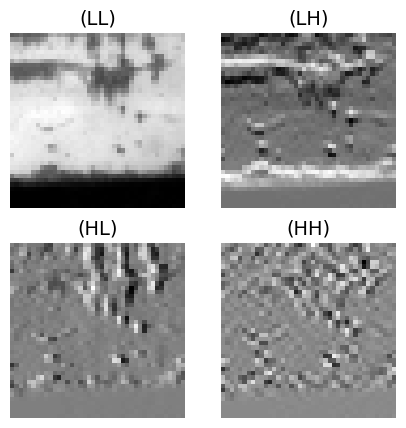

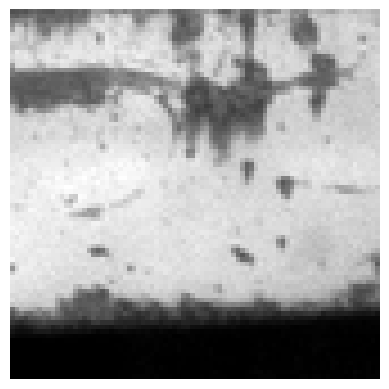

In [4]:
x, y = next(train_dataset.take(1).as_numpy_iterator())
x, y = x[0], y[0]
tr.display_image(x)
tr.display_image(tr.bands_to_image(x+y))

In [ ]:
train_size = 0
valid_size = 0

for f in train_files:
    d = tf.data.TFRecordDataset(f)
    record_size = d.reduce(0, lambda x, _: x + 1).numpy()
    train_size += record_size
    
for f in valid_files:
    d = tf.data.TFRecordDataset(f)
    record_size = d.reduce(0, lambda x, _: x + 1).numpy()
    valid_size += record_size

STEPS_PER_EPOCH = train_size // BATCH_SIZE
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

In [ ]:
model = get_model()
loss = get_loss()
optimizer = get_exp_optimizer(initial_learning_rate=0.001, decay_steps=TOTAL_STEPS, decay_rate=0.03)

In [5]:
# custom train loop

valid_prog = []
train_prog = []
checkpoint = os.path.join('saved_weights', 'exp_new')
if not os.path.exists(checkpoint):
    os.mkdir(checkpoint)
for epoch in range(EPOCHS):
    total_train_loss = 0
    train_batches = 0
    loss_value = 0
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            predictions = model(x_batch_train, training=True)
            loss_value = loss(y_batch_train, predictions)
        gradients = tape.gradient(loss_value, model.trainable_variables)

        # unsure if we should use norm or global norm
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, CLIP_NORM)
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
        
        total_train_loss += loss_value
        train_batches += 1
    print(optimizer.lr.numpy())
    # Validation loop
    """
    add validation losses for PSNR and SSIM
    """
    total_val_loss = 0
    val_batches = 0
    min_val_loss = float('inf')
    for x_batch_val, y_batch_val in valid_dataset:
        val_predictions = model(x_batch_val, training=False)        # unsure about training=False

        val_loss = loss(y_batch_val, val_predictions)
        total_val_loss += val_loss
        val_batches += 1
    
    avg_val_loss = total_val_loss / val_batches
    avg_train_loss = total_train_loss / train_batches
    train_prog.append(avg_train_loss)
    valid_prog.append(avg_val_loss)
    if (epoch % 5 == 0 or epoch == EPOCHS - 1) and avg_val_loss < min_val_loss and epoch > 15:
        min_val_loss = avg_val_loss
        model.save_weights(os.path.join(checkpoint, '2'+str(epoch)))
        
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss.numpy()}, Train loss: {avg_train_loss.numpy()}")

2024-02-27 09:12:07.239151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_49' with dtype string and shape [1]
	 [[{{node Placeholder/_49}}]]
2024-02-27 09:12:07.239610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_74' with dtype string and shape [1]
	 [[{{node Placeholder/_74}}]]


NameError: name 'model' is not defined

In [ ]:
np.save(os.path.join('saved_images', 'exp_800_train'), train_prog)
np.save(os.path.join('saved_images', 'exp_800_valid'), valid_prog)

In [ ]:
plt.plot(valid_prog)